In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

In [3]:
data_path = Config.data_path()/'amazon-fine-foods'; data_path.mkdir(parents=True, exist_ok=True)

In [4]:
data_path.ls()

[PosixPath('/home/jupyter/.fastai/data/amazon-fine-foods/finefoods.txt'),
 PosixPath('/home/jupyter/.fastai/data/amazon-fine-foods/finefoods_processed_sample.csv'),
 PosixPath('/home/jupyter/.fastai/data/amazon-fine-foods/finefoods_processed.csv'),
 PosixPath('/home/jupyter/.fastai/data/amazon-fine-foods/finefoods.csv')]

In [5]:
df = pd.read_csv(data_path/'finefoods.csv')

In [6]:
nans = df[df.isnull().any(axis=1)]; nans.head()

,product/productId,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text
25509,B000LKZB4Y,A36BVYD0NT7Z0F,NaN,0/0,5.0,1314576000,These are the best mints and no aspartame or BHT,I was so shocked to find out that almost all g...
33958,B00412W76S,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1/24,2.0,1173312000,NaN,I only used two maybe three tea bags and got p...
38874,B000AYDGZ2,A36BVYD0NT7Z0F,NaN,2/3,1.0,1278374400,doesn't anyone care that they are putting BHT ...,I called Kellogg's to see why Special K red be...
40548,B00020HHRW,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1/24,2.0,1173312000,NaN,I only used two maybe three tea bags and got p...
49800,B000CRHQN0,A2LYFY32LXQDON,NaN,0/0,2.0,1282608000,They were melted and the chocolate had turned ...,We love these bars but i won't order them ship...


In [7]:
print(df.shape)
print(nans.shape)

(568454, 8)
(43, 8)


In [8]:
df = df.drop(list(nans.index.values));

In [9]:
df.shape

(568411, 8)

Create two new columns:
 - one **concatenating the summary and text** since the two are both useful for sentiment analysis (this will be the independent variable for training)
 - the **sentiment of the review** (the dependent variable/label) which can be 'positive'/'negative'

In [10]:
separator = ' '
df["review/summary_and_text"] = df["review/summary"].map(str) + separator + df["review/text"]
df['label'] = df.apply(lambda row: 'positive' if row['review/score'] > 2.0 else 'negative', axis=1) 

In [13]:
df.sort_values(by=['product/productId'], inplace=True);
df.reset_index(drop=True, inplace=True)

In [14]:
df.head()

,product/productId,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text,review/summary_and_text,label
0,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1/1,4.0,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,chicken soup with rice months This is a fun wa...,positive
1,0006641040,A3KKR87BJ0C595,"Gretchen Goodfellow ""Lover of children's lit""",3/3,5.0,1111363200,"You'll use it once, you'll use it twice",One of my earliest memories is of this book. ...,"You'll use it once, you'll use it twice One of...",positive
2,0006641040,A1DJXZA5V5FFVA,A. Conway,0/0,5.0,1338249600,Must have.,I set aside at least an hour each day to read ...,Must have. I set aside at least an hour each d...,positive
3,0006641040,ACITT7DI6IDDL,shari zychinski,0/0,5.0,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,EVERY book is educational this witty little bo...,positive
4,0006641040,A3R5XMPFU8YZ4D,"Her Royal Motherliness ""Nana""",1/1,5.0,1233964800,so fun to read,This is my grand daughter's and my favorite bo...,so fun to read This is my grand daughter's and...,positive


# EDA

In [113]:
def ranged_multi_histogram(data, title, xlabel, ylabel, ranges, bins=50, figsize=(20,8)):
    rows = len(ranges) // 2
    fig, axes = plt.subplots(rows, 2, figsize=figsize)
    plt.suptitle(title)
    for idx, ax in enumerate(axes.flat):
        ax.hist(data, bins=50, range=ranges[idx])
        ax.set_ylabel(xlabel)
        ax.set_xlabel(ylabel)

#### **Unique products in the dataset**

In [15]:
len(df['product/productId'].unique())

74258

#### **Unique users**

In [18]:
len(df['review/userId'].unique())

256047

#### **Review scores**

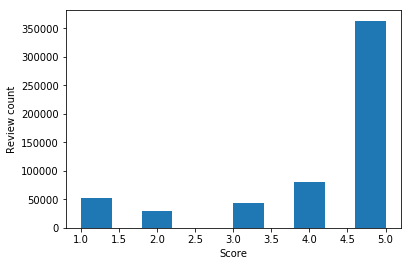

In [26]:
plt.hist(df['review/score']);
plt.xlabel('Score');
plt.ylabel('Review count');

Most reviews are positive - the dataset is unbalanced. It is also important to be aware that most people who write reviews are either very disappointed or very satisfied so there will likely be extremes of language in the text. This might be an issue when applying the model on more moderate reviews.

#### **Review word count**

In [155]:
review_word_counts = df.apply(lambda row: len(row['review/summary_and_text'].split(' ')), axis=1)

In [156]:
review_word_counts.min(), review_word_counts.max(), int(review_word_counts.mean())

(4, 3545, 86)

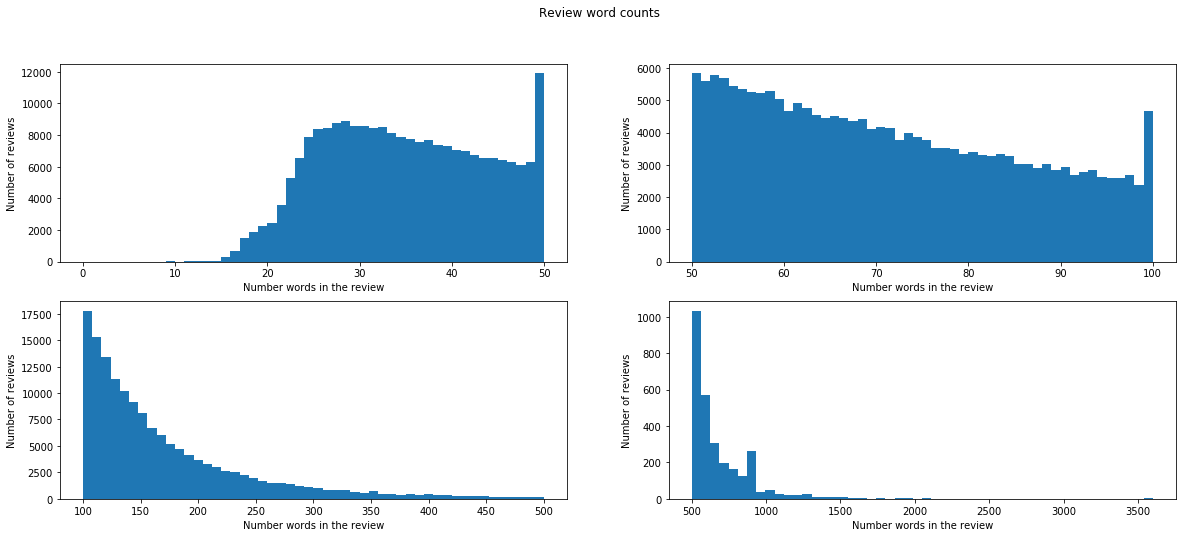

In [157]:
ranged_multi_histogram(review_word_counts, 'Review word counts', 'Number of reviews', 'Number words in the review',
                       ranges=[(0, 50), (50, 100), (100, 500), (500, 3600)])

#### **Reviews per product**

In [87]:
product_review_counts = df['product/productId'].value_counts()
product_review_counts.min(), product_review_counts.max(), int(product_review_counts.mean())

(1, 913, 7)

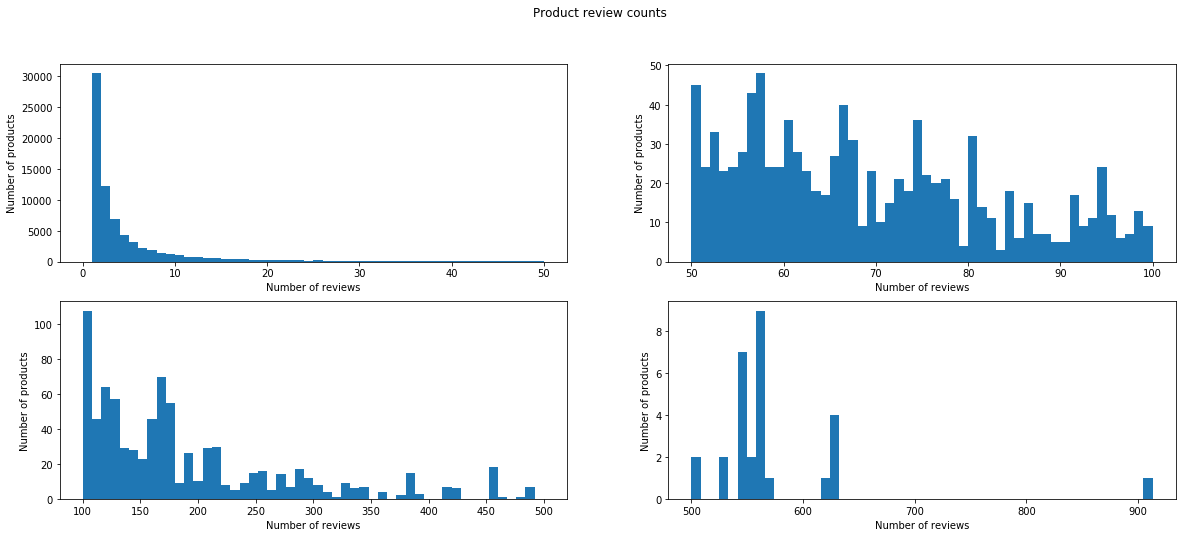

In [106]:
ranged_multi_histogram(product_review_counts, 'Product review counts', 'Number of products', 'Number of reviews',
                       ranges=[(0, 50), (50, 100), (100, 500), (500, 913)])

#### **Reviews per user**

In [99]:
user_review_counts = df['review/userId'].value_counts()
user_review_counts.min(), user_review_counts.max(), int(user_review_counts.mean())

(1, 448, 2)

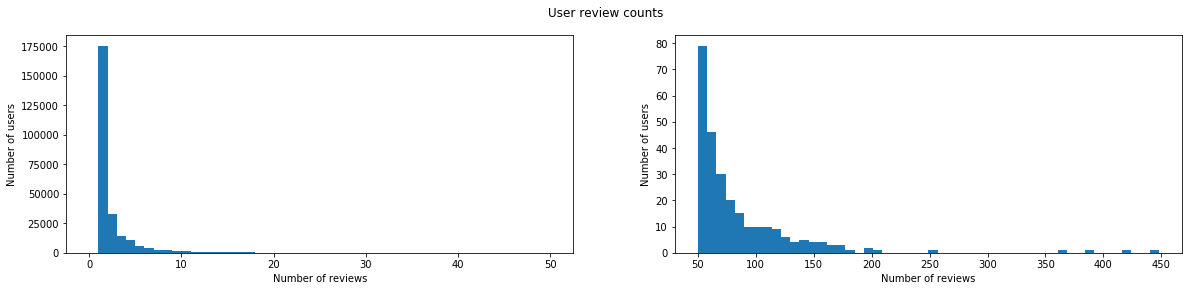

In [118]:
ranged_multi_histogram(user_review_counts, 'User review counts', 'Number of users', 'Number of reviews',
                       ranges=[(0, 50), (50, 448)], figsize=(20, 4))

#### **Reviews by year**

In [ ]:
from datetime import datetime

In [143]:
review_times = df.apply(lambda row: datetime.utcfromtimestamp(row['review/time']), axis=1).to_frame('time')
review_times.sort_values(inplace=True, by='time')
review_years = review_times.apply(lambda row: row['time'].year, axis=1)

In [144]:
review_years.min(), review_years.max(), review_years.median()

(1999, 2012, 2011.0)

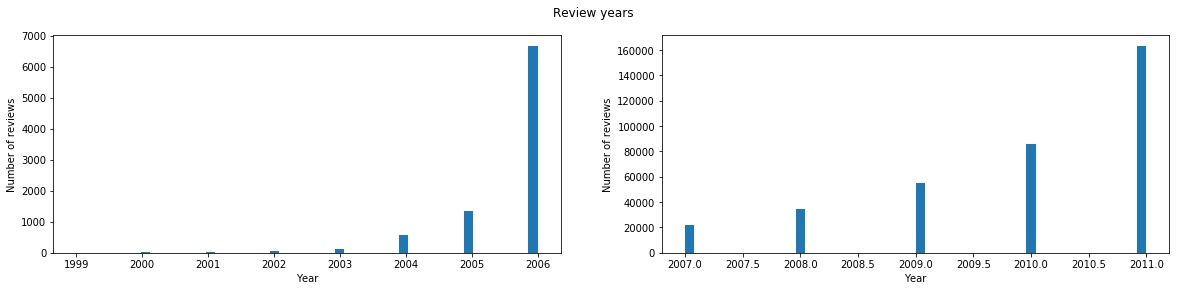

In [154]:
ranged_multi_histogram(review_years, 'Review years', 'Number of reviews', 'Year',
                       ranges=[(1999, 2006), (2007, 2011)], figsize=(20, 4))

Most reviews come from years 2008-2011. This might be relevant when using and evaluating our model. Although it is sensible to assume that the English vocabulary has not changed much for example between 1999 and 2011 and between 2011 and 2019 (if we were to deploy it on reviews written today), some new words might have entered the language that were not in usage then. But I think that is just something to keep in mind and most likely only a minor detail in this case.